Notebook for FFT based image segmentation
Chris Nelson, ORNL
2024

Process:
1)  Determine Window Size                                                   (can be provided manually variable 'winSz')
2)  Slice into image patches
3)  Calculate |FFT| of each patch
4)  PCA
5)  Downselect number of significant PCA components                         (can be provided manually variable 'compN')
6)  Determine clustering Hyperparameter via nearest neighbor statistics     (function is ctntools.Classification.clusteringSupportFuns import getNNbrThresh)
7)  Clustering
8)  Prune & reclassify clusters based on criteria:  e.g. Max # Clusters, Cluster min population, Cluster min population fraction. (RefMethod='maxN', 'minpop', and 'minfrac' respectively)
9)  Detemine class average |FFT|
10) Find min Score per point                        Stride<1 provides overlap, this section determines which patch & label is best
11) Create label mask size of image

Standard Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from git import Repo,  InvalidGitRepositoryError
import time

Custom GIT Imports

In [2]:
gitlocal = ''
for i in sys.path:
    temp=i.split('\\')
    if temp[-1]=='site-packages':
        gitlocal=i

In [3]:
#Set local git repository location
gitremote = 'https://github.com/ctnelson/ctntools.git'
gitl = os.path.join(gitlocal,'ctntools')
print(gitl)

c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\ctntools


In [4]:
#check for local repo, pull if found
#clone git repo if not found locally
if os.path.exists(gitl):
    try:
        my_repo = Repo(gitl)
        o = my_repo.remotes.origin
        o.pull()
    except InvalidGitRepositoryError:
        Repo.clone_from(gitremote, gitl)
        my_repo = Repo(gitl)
else:
    Repo.clone_from(gitremote, gitl)
    my_repo = Repo(gitl)
print(my_repo)

<git.repo.base.Repo 'c:\\programs\\Anaconda3\\envs\\gpuenv\\lib\\site-packages\\ctntools\\.git'>


Custom Imports

In [5]:
#Import custom functions from git repo
from ctntools.BaseSupportFunctions.createDataset import createDataset                   #create synthetic dataset
from ctntools.BaseSupportFunctions.plottingFuns import plotImStackGridColorbars         #quick helper function to plot image stacks & scalebars
from ctntools.SlidingWindow.swSegmentationFFT import swSegmentationFFT                  #classify an image by a sliding window FFT

# Image (Generate or Load)

In [6]:
### Input Image ###
input_image = None    #location of image for processing. If None a synthentic image is generated
#input_image = 'G:\My Drive\Programs\Python\CTNTOOLS Development\data\multicomponentIM.npy'

### Synthetic Dataset ###
#below is a 2 atom hex TMD type image
bounds = [0,128,0,64]                                                       #window
samplestep = .25                                                            #meshgrid sampling step
sampMesh = [bounds[0],bounds[1],samplestep,bounds[2],bounds[3],samplestep]  #meshgrid parameters for sampling
#Noise
countsPerPrimitive = 1000                                  #shot noise
baseNoiseRng = .5                                           #additive gaussian noise

c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Text(0.5, 1.0, 'Dataset')

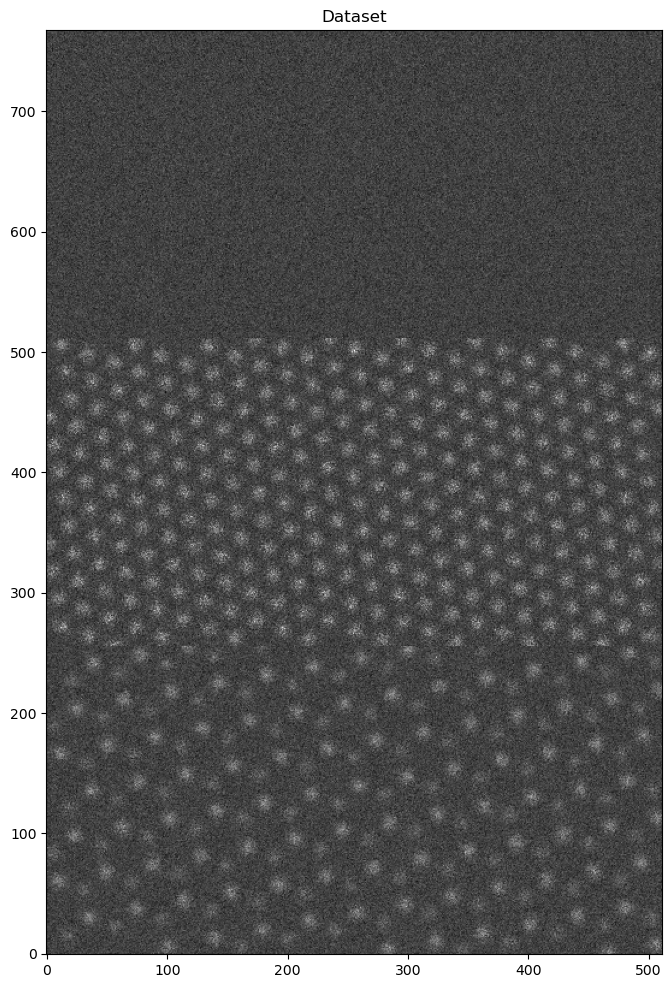

In [7]:
if not (input_image is None):
    #Load Image
    im = np.load(input_image)
else:
    #Create synthetic dataset   
    #General
    samplestep = .25 

    mag=10                                                      #basis vector magnitude
    alpha = np.deg2rad(60)                                      #internal angle
    atheta = np.deg2rad(10)                                     #a vector orientation
    a=[np.cos(atheta)*mag, np.sin(atheta)*mag]                  #a basis vector
    b=[np.cos(alpha+atheta)*mag, np.sin(alpha+atheta)*mag]      #b basis vector

    # Section 1 (primitive 1)
    #Window
    bounds1 = [0,128,0,64]                                                          #boundaries
    sampMesh1 = [bounds1[0],bounds1[1],samplestep,bounds1[2],bounds1[3],samplestep]  #meshgrid parameters for sampling
    #Primitive
    primitive1 = [[1/3,1/3,1,1,1,0],[2/3,2/3,2,1,1,0]]                               #[a, b, A, s1, s2, theta]
    im1, _, _, atoms1,_,_, mgparams1, intensityScalar1 = createDataset(bounds=bounds1, method='Grid',sampMesh=sampMesh1, primitive=primitive1 ,a=a, b=b, countsPerUnit=countsPerPrimitive, baseNoiseRng=baseNoiseRng)

    # Section 2 (primitive 2)
    #Window
    bounds2 = [0,128,64,128]                                                          #boundaries
    sampMesh2 = [bounds2[0],bounds2[1],samplestep,bounds2[2],bounds2[3],samplestep]  #meshgrid parameters for sampling
    #Primitive
    primitive2 = [[1/3,1/3,2,1,1,0],[2/3,2/3,2,1,1,0],[0,0,2,1,1,0]]                               #[a, b, A, s1, s2, theta]
    im2, _, _, atoms2,_,_, mgparams2, intensityScalar2 = createDataset(bounds=bounds2, method='Grid',sampMesh=sampMesh2, primitive=primitive2, xy0=np.array([0,0]), a=a, b=b, countsPerUnit=countsPerPrimitive, baseNoiseRng=baseNoiseRng)

    im = np.random.randn(np.round(192/samplestep).astype('int'),np.round(128/samplestep).astype('int'))*baseNoiseRng
    b1=np.round(np.array(bounds1)/samplestep).astype('int')
    b2=np.round(np.array(bounds2)/samplestep).astype('int')
    im[b1[2]:b1[3],b1[0]:b1[1]] = im1
    im[b2[2]:b2[3],b2[0]:b2[1]] = im2

#display
fig, ax = plt.subplots(1, 1, figsize=(12,12), dpi = 100)
ax.imshow(im,cmap='gray',origin='lower')
ax.set_title('Dataset')

# Segmentation (Default Settings)

In [8]:
#Execute Labeling on Image with defaults 
#(note: while the default execution includes scoreMethod='diff2Avg' the classAvg is calculated and returned. If not this may be NoneType)
tic = time.time()
imLabel, classAvg = swSegmentationFFT(im)
toc = time.time()-tic
print('Execuation Time: {:.3f} s'.format(toc))

Execuation Time: 2.084 s


Text(0.5, 1.0, 'Label Mask')

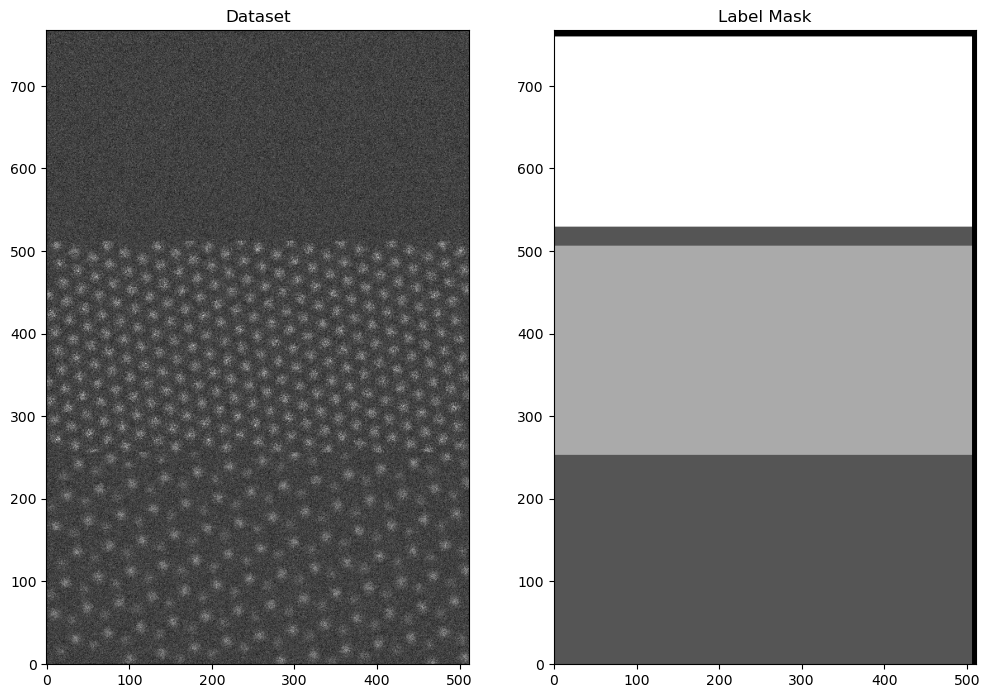

In [9]:
#Display Results
fig, ax = plt.subplots(1, 2, figsize=(12,6*im.shape[0]/im.shape[1]), dpi = 100)
ax[0].imshow(im,cmap='gray',origin='lower')
ax[0].set_title('Dataset')
ax[1].imshow(imLabel,cmap='gray',origin='lower')
ax[1].set_title('Label Mask')

# w/ Execution Details

Scale estimate by FFT [10.00, 35.23]
Window Size: 46x46
Stride: 23x23


calculating FFTs: 100%|██████████| 672/672 [00:00<00:00, 3975.30it/s]


Autoselected 3 PCA Components
threshold nearest-neighbor distance: 0.69
DBSCAN cluster number: 5
2 classes are below the population limit (27) and will be removed


c:\programs\Anaconda3\envs\gpuenv\lib\site-packages\colorspacious\ciecam02.py:333: RuntimeWarning: invalid value encountered in true_divide
  t = (C


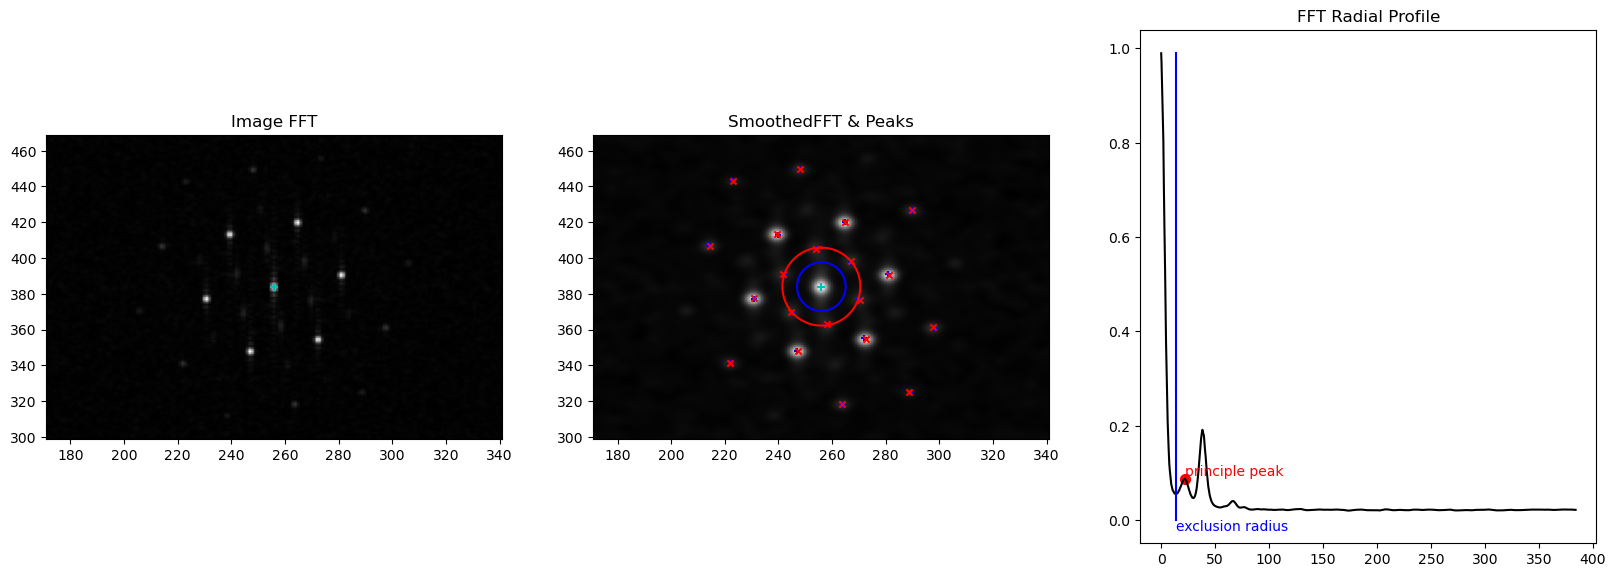

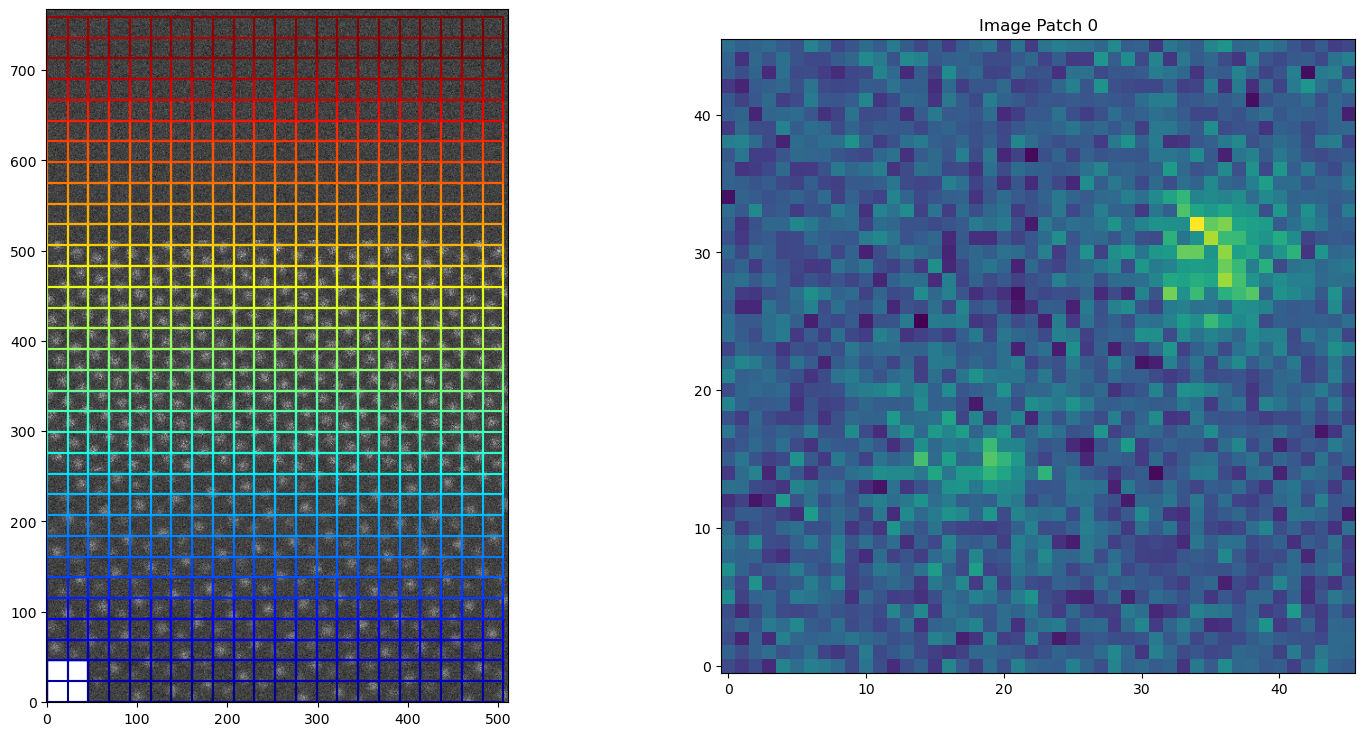

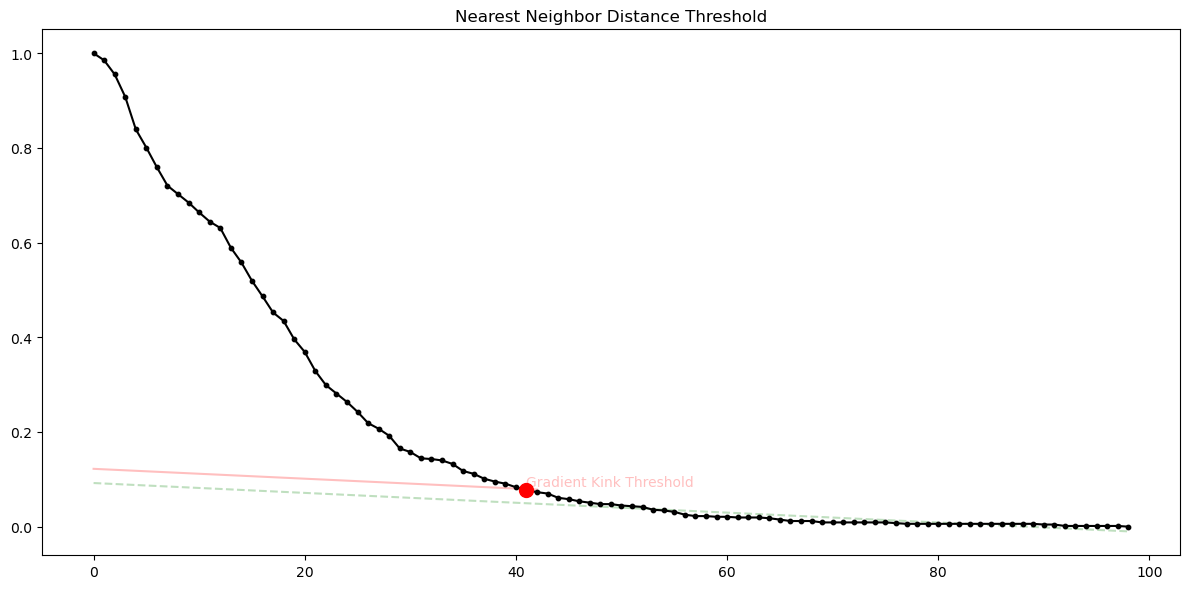

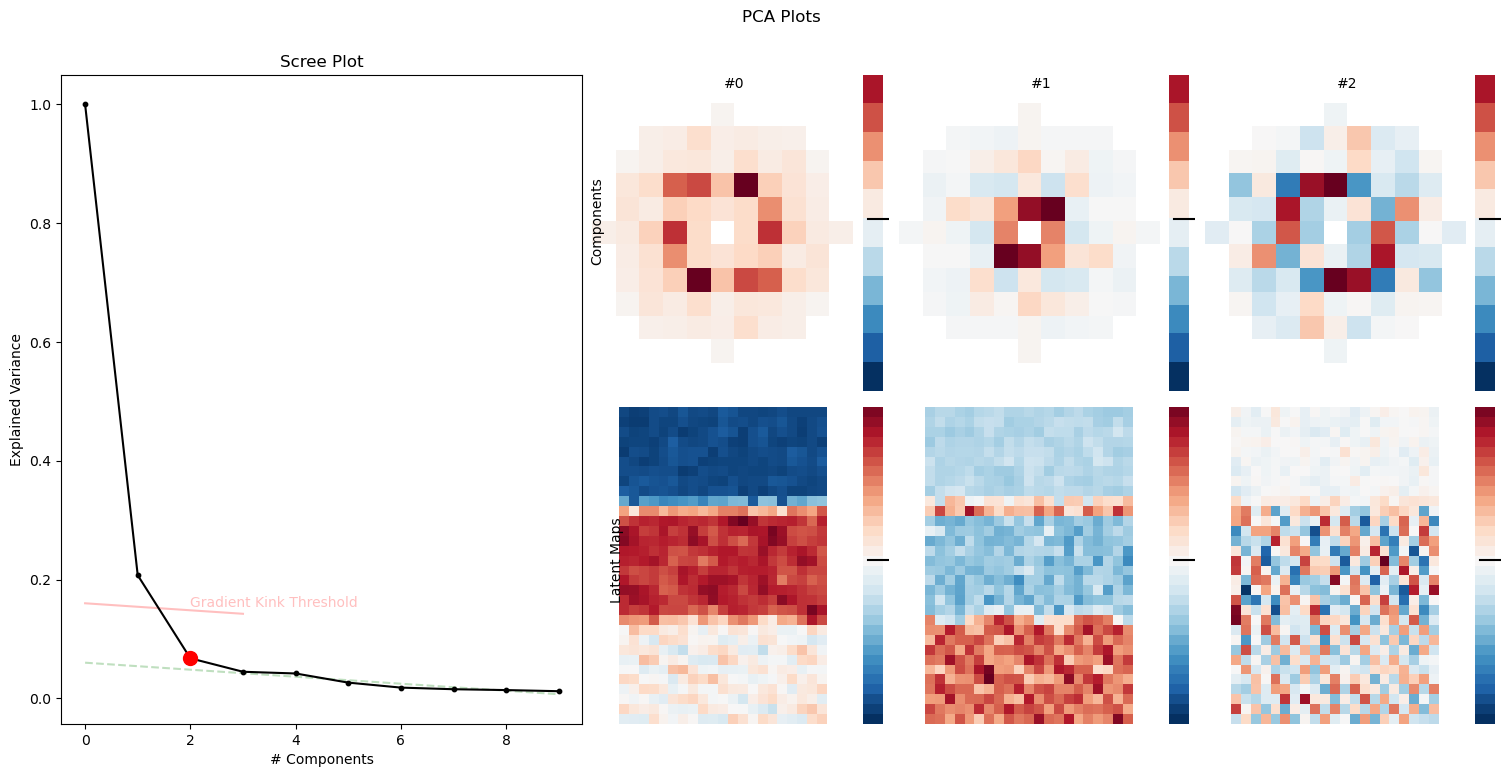

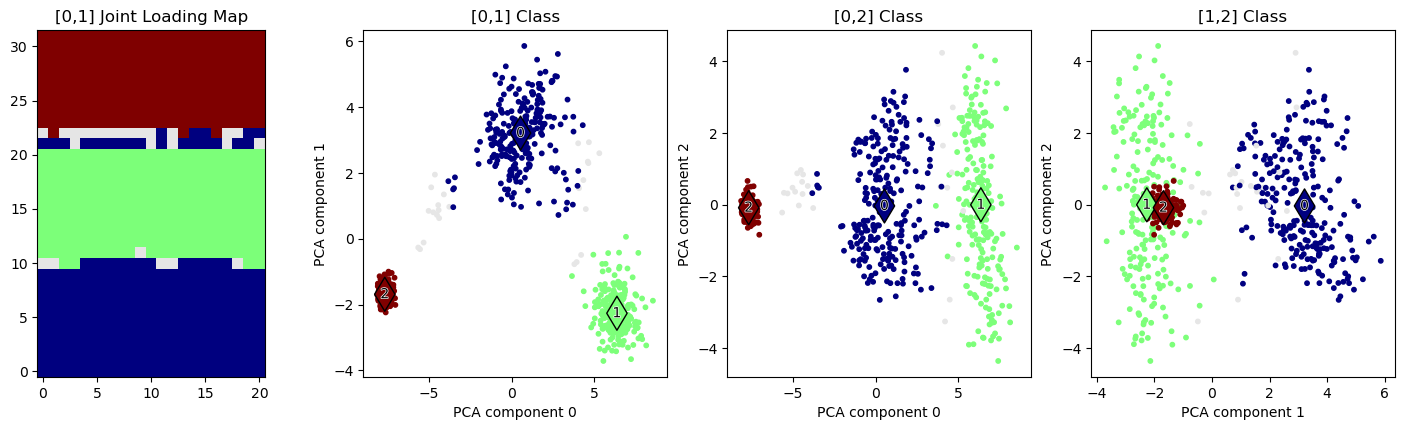

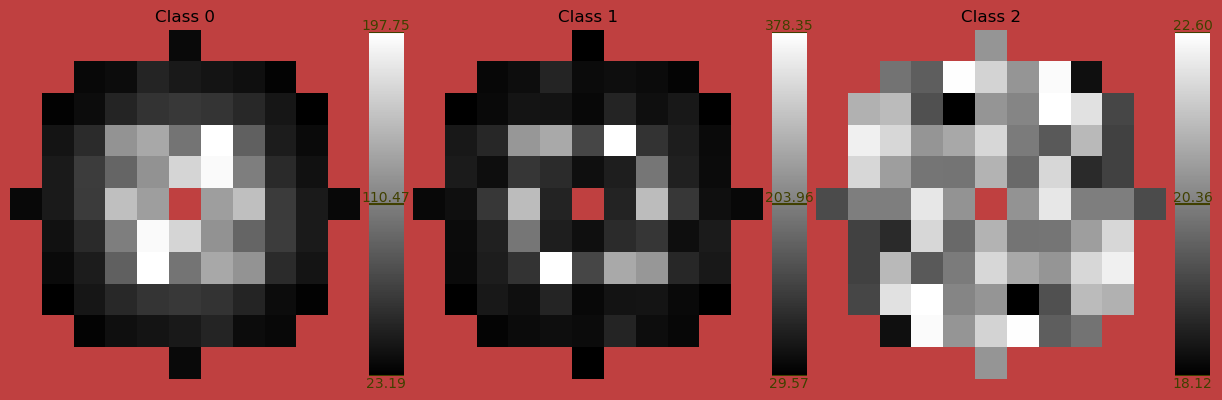

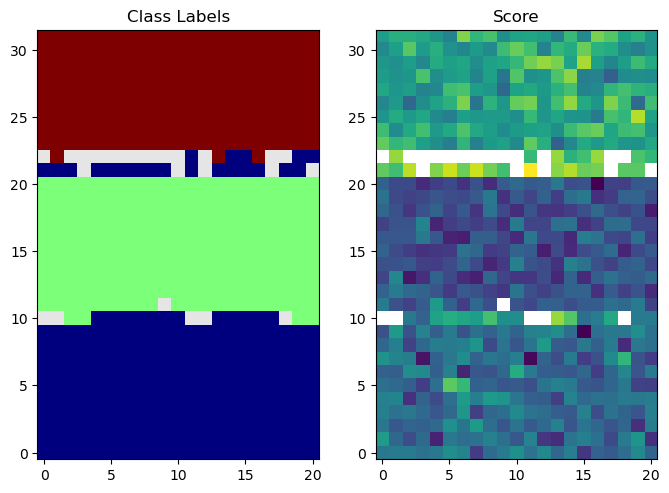

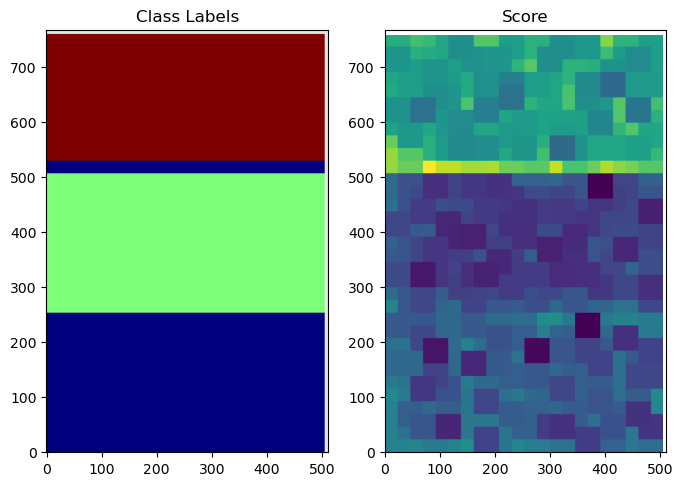

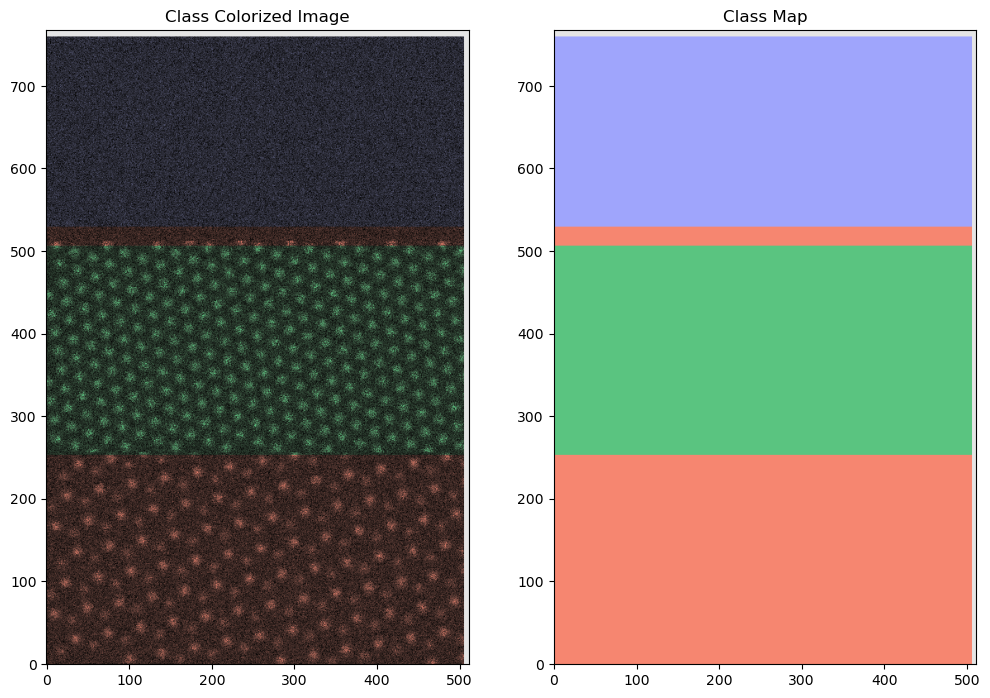

In [10]:
#set verbose=1 for minor (primarily text) messages, verbose=2 for detailed
imLabel, classAvg = swSegmentationFFT(im, verbose=2)

# Returned Representative |FFT| Classes

Three options for the returned Class 'Average', either the average of all classes, median, or the inverted PCA representation. returnClass='Avg','Med', or 'PCAinv' respectively.

In [11]:
#Class Average                      (default returnClass='Avg')
imLabel_Mean, class_Mean = swSegmentationFFT(im, returnClass='Avg')
#Class Median                      (default returnClass='Med')
imLabel_Med, class_Med = swSegmentationFFT(im, returnClass='Med')
#PCA cluster center respresentation (returnClass='PCAinv')
imLabel_PCA, class_PCA = swSegmentationFFT(im, returnClass='PCAinv')

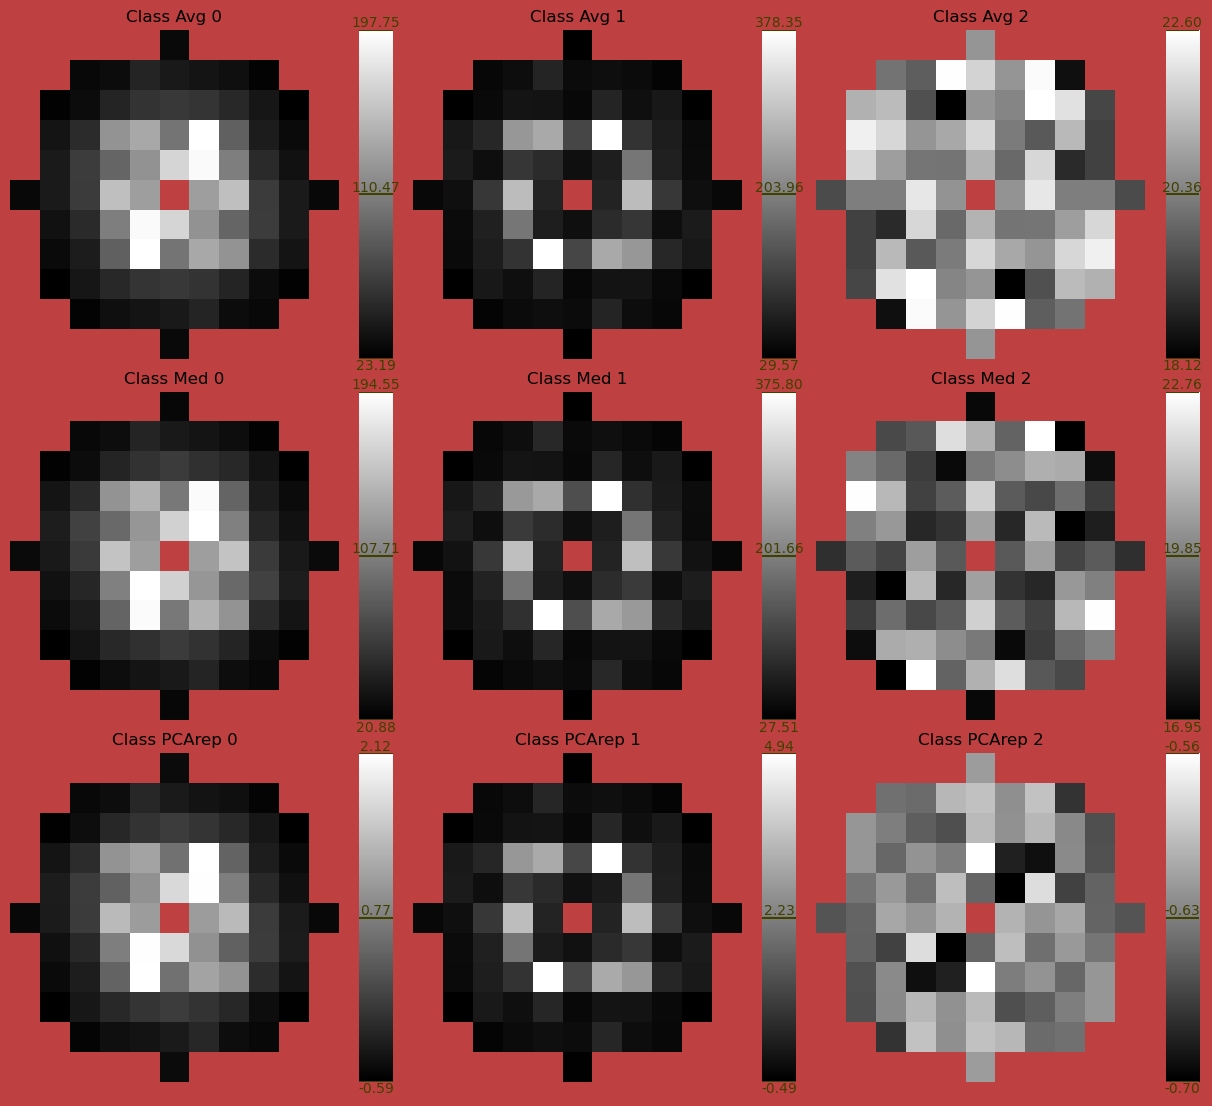

In [12]:
#Display
imStack = np.append(np.append(class_Mean,class_Med,axis=2),class_PCA,axis=2)
axLbls=['Class Avg {:d}'.format(i) for i in np.arange(class_Mean.shape[-1])] + ['Class Med {:d}'.format(i) for i in np.arange(class_Med.shape[-1])] + ['Class PCArep {:d}'.format(i) for i in np.arange(class_PCA.shape[-1])]
_,_,fig = plotImStackGridColorbars(imStack,[3,class_Mean.shape[-1]], fig_hspace=.1, axLbls=axLbls)
fig.set_facecolor([.75,.25,.25])

# Tuning the Clustering (Hyperparameter)

In [16]:
#array of clustering parameter values
hyperparam = np.array([.5,1.,2,3])

#get cluster maps
imClass = np.ones((im.shape[0],im.shape[1],hyperparam.size))*np.nan
for i in range(hyperparam.size):
    imClass[:,:,i] = swSegmentationFFT(im, clustHyperparameter=hyperparam[i])[0]

Text(0.5, 0.98, 'Class Maps vs. Clustering Hyperparameter')

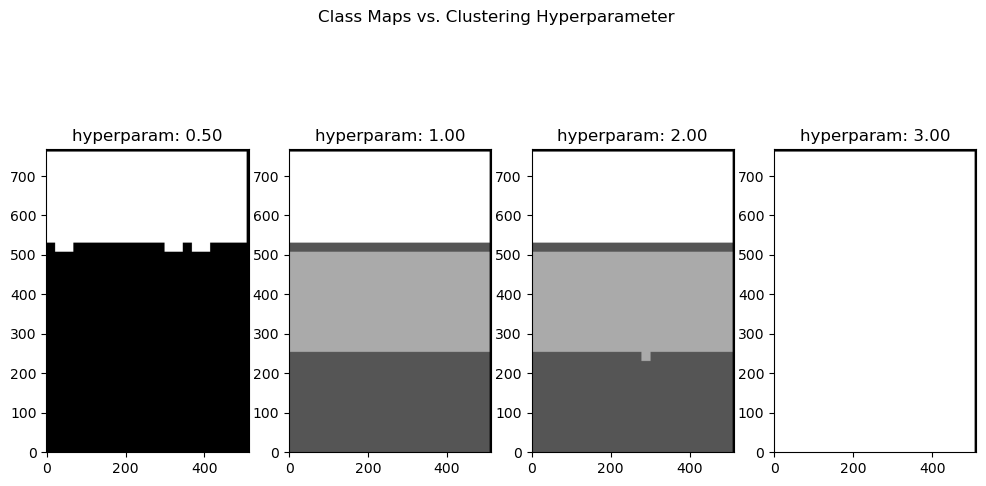

In [18]:
#Display
fig, ax = plt.subplots(1, hyperparam.size, figsize=(12,6))
for i in range(hyperparam.size):
    ax[i].imshow(imClass[:,:,i], origin='lower', cmap='gray')
    ax[i].set_title('hyperparam: {:.2f}'.format(hyperparam[i]))
fig.suptitle('Class Maps vs. Clustering Hyperparameter')

# Normalization

Depends on use case whether average intensity should be considering in classification.

A fair bit of redundancy in available options. Data can be normalized for both the initial image patches and the |FFT| fed into PCA ('imNormalize' and 'pcaNormalize').
Available options are 'none', 'Global', and 'Frame' which either skip, or use global or frame-wise normalization.

Also, the zero-frequency FFT point can be clipped out so mean values are ignored by pca clustering. 'fft_zeroflag' set to False will ignore it.

In [28]:
#Ignoring mean via fft_zeroflag=False
imLabel, class_noMean = swSegmentationFFT(im, fft_zeroflag=False)
#Include mean via fft_zeroflag=True
imLabel, class_wMean = swSegmentationFFT(im, fft_zeroflag=True)

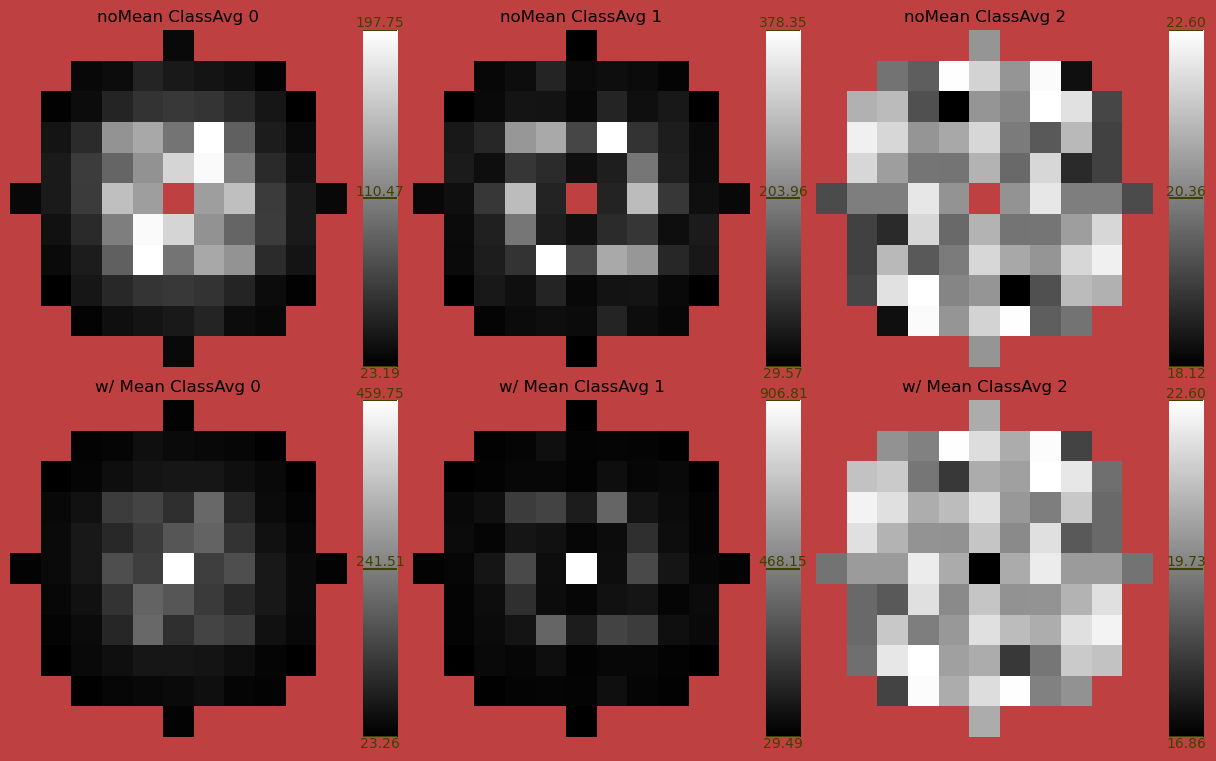

In [29]:
#Display
imStack = np.append(class_noMean,class_wMean,axis=2)
axLbls=['noMean ClassAvg {:d}'.format(i) for i in np.arange(class_Mean.shape[-1])] + ['w/ Mean ClassAvg {:d}'.format(i) for i in np.arange(class_Med.shape[-1])]
_,_,fig = plotImStackGridColorbars(imStack,[2,class_noMean.shape[-1]], fig_hspace=.1, axLbls=axLbls)
fig.set_facecolor([.75,.25,.25])